In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [0]:
!rm 'RAVDESS.zip'

In [0]:
# Download the pre processed data set
file_id = '1xw1JXzQpQm6lspTD2eg6Ldk3QZvRz3o0' 

destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [0]:
!ls -lh

total 12M
-rw-r--r-- 1 root root 2.5M Dec 13 21:24 best_model.h5
drwxr-xr-x 3 root root 4.0K Dec 13 21:22 RAVDESS
-rw-r--r-- 1 root root 8.6M Dec 13 22:35 RAVDESS.zip
drwxr-xr-x 1 root root 4.0K Dec 12 16:48 sample_data


In [0]:
!rm -rf 'RAVDESS/train_valid/'

In [0]:
!unzip -n RAVDESS.zip

Archive:  RAVDESS.zip
   creating: RAVDESS/train_valid/
   creating: RAVDESS/train_valid/valid/
   creating: RAVDESS/train_valid/valid/happy/
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-02-02-07-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-01-06-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-02-01-11-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-02-01-05-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-01-21-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-02-01-14-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-01-22-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-02-09-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-01-08-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-02-15-00.nparray  
  inflating: RAVDESS/train_valid/valid/happy/03-01-03-02-01-01-20-00

In [0]:
!ls RAVDESS/train_valid/train -lh
!ls RAVDESS/train_valid/valid/angry -lh

total 28K
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 angry
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 calm
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 disgust
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 fearful
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 happy
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 sad
drwxr-xr-x 2 root root 4.0K Dec 13 14:14 surprised
total 888K
-rw-r--r-- 1 root root 35K Dec 13 14:14 03-01-05-02-01-01-03-00.nparray
-rw-r--r-- 1 root root 23K Dec 13 14:14 03-01-05-02-01-01-11-00.nparray
-rw-r--r-- 1 root root 21K Dec 13 14:14 03-01-05-02-01-01-17-00.nparray
-rw-r--r-- 1 root root 24K Dec 13 14:14 03-01-05-02-01-02-05-00.nparray
-rw-r--r-- 1 root root 33K Dec 13 14:14 03-01-05-02-01-02-06-00.nparray
-rw-r--r-- 1 root root 35K Dec 13 14:14 03-01-05-02-01-02-10-00.nparray
-rw-r--r-- 1 root root 29K Dec 13 14:14 03-01-05-02-01-02-12-00.nparray
-rw-r--r-- 1 root root 33K Dec 13 14:14 03-01-05-02-01-02-13-00.nparray
-rw-r--r-- 1 root root 25K Dec 13 14:14 03-01-05-02-01-02-16-00.nparr

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [0]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

emotions = os.listdir(train_dir)
emotions.sort()
num_of_emotions = len(emotions)
print('Number of emotions: ' + str(num_of_emotions))
print('Emotions: ' + str(emotions))

def load_data_from_folder(emotions, folder):
  data = []


  for emotion in emotions:
    container_folder = folder + '/' + emotion + '/'
    mfcc_files = os.listdir(container_folder)
    for mfcc_file in mfcc_files:
      mfcc = np.loadtxt(container_folder + mfcc_file, delimiter=',')
      data.append([emotion, mfcc])

  df = pd.DataFrame(data, columns=['emotion', 'mfcc'])
  df = pd.get_dummies(df, columns=["emotion"])
  return df

def find_min_shape(train_df, valid_df):
  appended_df = train_df.append(valid_df)
  min_shape = np.amin(appended_df['mfcc'].map(lambda x: x.shape), axis=0)
  return min_shape

def prepare_df(df, new_shape):

  df['mfcc'] = df['mfcc'].map(lambda x: x[:, 0:min_shape[1]])
  df['mfcc'] = df['mfcc'].map(lambda x: x.flatten())
  return df

train_df = load_data_from_folder(emotions, train_dir)
valid_df = load_data_from_folder(emotions, validation_dir)

min_shape = find_min_shape(train_df, valid_df)
print('The minimum shape is: ' + str(min_shape))

train_df = prepare_df(train_df, min_shape)
valid_df = prepare_df(valid_df, min_shape)

Number of emotions: 7
Emotions: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised']
The minimum shape is: (13, 50)


In [0]:
emotion_columns = train_df.columns.to_list()
emotion_columns.remove('mfcc')

x_train = train_df['mfcc'].values.tolist()
x_train = np.expand_dims(x_train, axis=2)

y_train = train_df[emotion_columns].values

x_test = valid_df['mfcc'].values.tolist()
x_test = np.expand_dims(x_test, axis=2)

y_test = valid_df[emotion_columns].values

In [0]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
epochs = 400
batch_size = 16
dropout_low = 0.15
dropout_medium = 0.25
dropout_high = 0.5
best_model_path = 'best_model.h5'
initializer = keras.initializers.glorot_uniform(seed=42)
optimizer = keras.optimizers.adam(lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', mode='min', save_best_only=True)
regularizer = l2(0.001)

(650, 1)


In [0]:
model = Sequential()

model.add(Conv1D(128, 5, padding='same', input_shape=x_train[0].shape, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_high))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Conv1D(32, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_high))
model.add(MaxPooling1D(pool_size=(4)))
#model.add(Conv1D(32, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
#model.add(Activation('relu'))
#model.add(Conv1D(16, 5, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
#model.add(Activation('relu'))
#model.add(Dropout(rate=dropout_high))
#model.add(MaxPooling1D(pool_size=(4)))
model.add(Flatten())
model.add(Dense(15*num_of_emotions, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_medium))
model.add(Dense(5*num_of_emotions, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(rate=dropout_low))
model.add(Dense(num_of_emotions, kernel_initializer=initializer, kernel_regularizer=regularizer, bias_regularizer=regularizer))
model.add(Activation('softmax'))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 650, 128)          768       
_________________________________________________________________
activation_1 (Activation)    (None, 650, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 650, 64)           41024     
_________________________________________________________________
activation_2 (Activation)    (None, 650, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 650, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 162, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 162, 64)          

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])

saved_model = load_model(best_model_path)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 469 samples, validate on 203 samples
Epoch 1/400





469/469 [==============================] - 4s 9ms/step - loss: 2.3819 - acc: 0.1407 - val_loss: 2.3313 - val_acc: 0.1872
Epoch 2/400
469/469 [==============================] - 3s 7ms/step - loss: 2.3064 - acc: 0.1599 - val_loss: 2.2845 - val_acc: 0.1773
Epoch 3/400
469/469 [==============================] - 3s 7ms/step - loss: 2.2543 - acc: 0.1706 - val_loss: 2.2336 - val_acc: 0.1872
Epoch 4/400
469/469 [==============================] - 3s 7ms/step - loss: 2.1533 - acc: 0.2431 - val_loss: 2.1609 - val_acc: 0.2857
Epoch 5/400
469/469 [==============================] - 3s 7ms/step - loss: 2.0078 - acc: 0.3433 - val_loss: 2.0523 - val_acc: 0.3695
Epoch 6/400
469/469 [==============================] - 3s 7ms/step - loss: 1.8912 - acc: 0.3902 - val_loss: 2.0092 - val_acc: 0.3498
Epoch 7/400
469/469 [==============================] -

In [0]:
train_evaluated = saved_model.evaluate(x_train, y_train)
validation_evaluated = saved_model.evaluate(x_test, y_test)
print('Training Accuracy: %.3f%%, Training Loss: %.3f' % (train_evaluated[1]*100, train_evaluated[0]))
print('Validation Accuracy: %.3f%%, Validation Loss: %.3f' % (validation_evaluated[1]*100, validation_evaluated[0]))

203/203 [==============================] - 0s 1ms/step
Training Accuracy: 100.000%, Training Loss: 0.459
Validation Accuracy: 44.828%, Validation Loss: 1.706


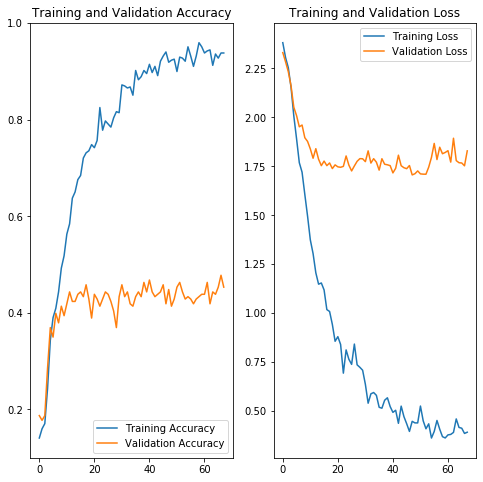

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
y_pred_classes = saved_model.predict_classes(x_test)
y_test_classes = []
for y_test_class in y_test:
  y_test_classes.append(np.where(y_test_class == 1)[0][0])

emotions_confusion_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(classification_report(y_test_classes, y_pred_classes, target_names=emotions))

              precision    recall  f1-score   support

       angry       0.65      0.69      0.67        29
        calm       0.73      0.66      0.69        29
     disgust       0.43      0.41      0.42        29
     fearful       0.38      0.52      0.43        29
       happy       0.33      0.24      0.28        29
         sad       0.13      0.10      0.12        29
   surprised       0.44      0.52      0.48        29

    accuracy                           0.45       203
   macro avg       0.44      0.45      0.44       203
weighted avg       0.44      0.45      0.44       203



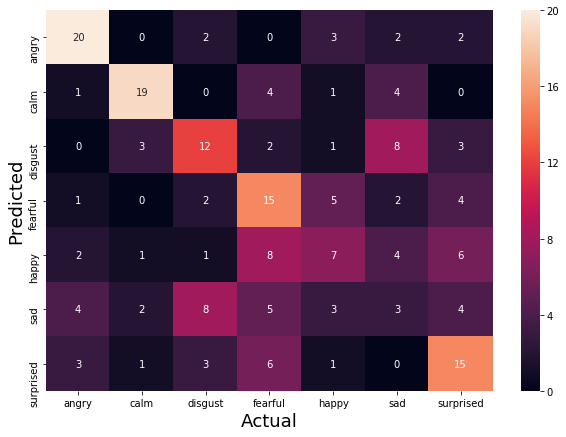

In [0]:
emotion_confusion_df = pd.DataFrame(emotions_confusion_matrix, index = emotions,
                  columns = emotions)
plt.figure(figsize = (10,7))
sn.heatmap(emotion_confusion_df, annot=True)
plt.xlabel('Actual', fontsize=18)
plt.ylabel('Predicted', fontsize=18)
plt.show()